# **MDX 데이터 분석하기**
https://pypi.org/project/mdict-utils/
1. **MDX 사전파일을** 활용하여 객체에 구분하기
1. 각 사전의 첫번째 의미를 통해서 **NER** 사전 만들기
1. 추후에 보완을 해서 wordnet 으로 강화하기

## **1 데이터 불러오기**
작업한 내용을 대상으로 중분류 내용 추가하기
- 법률, 식품, 자동차 등 중분류 내용이 당장은 필요가 없어 보인다.
- 작업을 진행하면서 필요하면 추가하기

In [1]:
import pickle
# with open('data/nerDict.pk', 'wb') as handle:
#     pickle.dump(nerDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/nerDict.pk', 'rb') as handle:
    nerDict = pickle.load(handle)
nerDict.shape

(388091, 2)

In [2]:
query     = "너비아니"
q_data    = nerDict[nerDict.Text == query].Data.values.tolist()
itemIndex = nerDict.Text.values.tolist()
itemData  = nerDict.Data.values.tolist()
q_data[0]

[('명사',
  ['명사',
   '얄팍하게 저며 갖은 양념을 하여 구운 쇠고기.',
   '¶ 석쇠에 너비아니를 구우니 연기가 올라왔다./송 씨는 새로 구워 온 너비아니 접시를 상 위에 올려놓으며, 신호의 눈치를 살폈다.≪최일남, 거룩한 응달≫\r\n'])]

In [3]:
# 고유 단어는 추출한 결과 32만개가 추출된다
itemIndexTemp = list(set(itemIndex))
len(itemIndexTemp), len(itemIndex)

(320585, 388091)

## **2 N-Gram 데이터**
**itemIndexTemp** 를 활용하며 고유단어 찾기

In [4]:
import pandas as pd
menus = pd.read_csv('data/muyong_menus.csv', encoding='ms949')
menus = menus.dropna(subset=['메인1', '메인2'])
menus = menus.fillna('')  # NaN 값을 지운다
menus.head(2)

,년도,주차,요일,구분,메인1,메인2,메인3,메인4,메인5,메인6,메인7,메인8,메인9,메인10,Unnamed: 14
1,2017,52,화,중식,황태미역국,매콤제육볶음,해물볶음우동,팽이맛살계란전,양상추샐러드,흑임자D,치커리사과겉절이,양념깻잎지,포기김치,,
2,2017,52,수,중식,육개장,사천식칠리탕수육,카레라이스,멸치꽈리볶음,사과단감샐러드,훈제오리야채겨자무침,콩나물매콤무침,포기김치,,,


In [5]:
# DataFrame 에서 고유 Token List 추출
tokens, result = [], []
for _ in menus.columns[4:]:
    tokens += menus[_].values.tolist()

# &, %, ., / 등의 제거 후, 고유 Token 문서 만들기 
import re
for _ in tokens:
    _temp = re.findall(r"\w+", _)
    if _temp:  result += _temp
tokens = list(set(result))
print(len(tokens)), " ".join(tokens[:25])

2903


(None,
 '갈비산적데리조림 부추팽이무침 오징어다리야채초무침 돈안심계란장조림 비엔나브로컬리볶음 단호박고구마범벅 파채 얼큰동태찌개 고추장양념비엔나볶음 숙주나물무침 돈육땅콩강정 달래상추겉절이 콩가루배춧국 제육짜장불고기 닭단호박떡찜 풋고추양파무침 미트볼조림 얼큰오징어무국 소고기버섯만두전골 오징어미나리초무침 시금치 불고기야채비빔밥 파인D 훈제오리샐러드 얼근마파두부')

In [6]:
# Okt 모듈로 명사만 찾기 (대중적 선별기준)
from konlpy.tag import Okt
token_Okt = Okt().morphs(" ".join(tokens))
len(tokens), len(token_Okt)

/home/markbaum/Python/nltk/lib/python3.6/site-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


(2903, 8965)

In [47]:
# N-Gram 유용한 값 찾기
n_gram, tokeNgram = 4, []
def ngram(token, n):
    return [token[_: _+n] for _ in range(0, (len(token)-n+1))]

for _ in tokens:
    tokeNgram += ngram(_, n_gram)

from nltk import Text
ngramObj = Text(tokeNgram)   # [list] 객체로 Text 객체의 생성

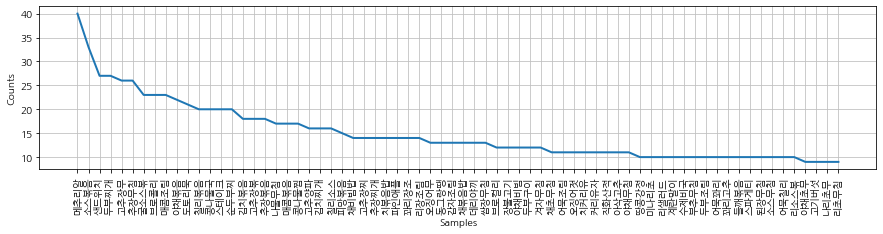

In [48]:
%matplotlib inline
from matplotlib import rc, rcParams
import matplotlib.pyplot as plt
rc('font', family=['NanumGothic','Malgun Gothic']) # 한글의 표시
rcParams['axes.unicode_minus'] = False             # '-' 표시의 처리
plt.figure(figsize=(15, 3))  # 파레트 설정
ngramObj.plot(70)

In [58]:
[_ for _ in itemIndexTemp if _ == "매실"]

['매실']

In [57]:
# itemIndexTemp : NER 객체어 사전
valid_token = []
unvalid_token = []
voca_tokens = ngramObj.vocab().most_common()

from tqdm import tqdm
for _ in tqdm(voca_tokens):
    if _[0] in itemIndexTemp: valid_token.append(_[0])
    else: unvalid_token.append(_[0])

# 유효하게 추출된 단어는 96개
len(valid_token), len(unvalid_token)

(96, 5458)

In [ ]:
# 별도 사전을 활용하기 보단, 표준국어를 쓰자
# 여기서도 구분되지 않는 내용은 띄어쓰기로 구분하면 된다!!

# **요리 데이터 MDX 내용 살펴보기**
표준국어대사전에는 "굴소스" 등의 식재료 고유이름이 없는 단어들이 많아서 문제가 있었다
- mdict -x dict.mdx --exdb
- 요리법 데이터 사전 전처리 작업

In [40]:
import sqlite3
import pandas as pd
# Create your connection.
conn = sqlite3.connect('backup/recipe.db')
resp = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0]  for name in resp]
tableNames

['meta', 'mdx']

In [42]:
%%time
df = pd.read_sql_query("SELECT * FROM {}".format(tableNames[1]), conn)
df.head(2)

CPU times: user 11.8 ms, sys: 278 µs, total: 12.1 ms
Wall time: 10.7 ms


,entry,paraphrase
0,가오리조림,가오리 ...1/2마리 생강 ........2통 <br>\r\n마늘 ...........
1,가오리찜,가오리(中) ······· 1마리 <br>\r\n실파 ·········2뿌리 <br...


In [27]:
ngramTokens = list(ngramObj.vocab().keys())

result = []
for _ in ngramObj.vocab().most_common():
    if _[0] in ngramTokens:
        result.append(_)
    else:
        print(_[0])
# result

In [30]:
list(ngramObj.vocab().keys())[:10]

['갈비산적데',
 '비산적데리',
 '산적데리조',
 '적데리조림',
 '부추팽이무',
 '추팽이무침',
 '오징어다리',
 '징어다리야',
 '어다리야채',
 '다리야채초']

## **2 청심중고교 메뉴 데이터 호출**
무영 메뉴작업 목록 호출하기
```python
from muyong.food import menu_chungsim
from tqdm import tqdm
date   = [str(_).split(" ")[0][:-3]  for _ in pd.date_range(start='1/1/2017', end="8/1/2019", freq='MS')]
result = [menu_chungsim(_).values.tolist()  for _ in tqdm(date)]
temp   = []
for _ in result:
    temp.extend(_)
temp = pd.DataFrame(temp, columns = ["Date", "조식", "중식", "석식"])
```

In [ ]:
# 2017-01-01 부터 수집 가능합니다.
import pandas as pd
df = pd.read_csv('data/menu_chungsim.csv')
df.head(2)

In [ ]:
import pandas as pd
df = pd.read_csv('data/menu_chungsim.csv')
df.loc[0]['석식']

## **3 성균관 대학교 메뉴 데이터 호출**
무영 메뉴작업 목록 호출하기 : 1년 전까지만 호출가능
```python
div class="weekly_list"
div class="tabCon listcon1"
div class="weeListWrap"   # div class="weeListTit" : 날짜만 추출시
idx_date_range = [_.date().strftime("%Y-%m-%d")  
    for _ in pd.date_range(start=idx_date, periods=len(menu_detail))]
```